# Analisi preliminari

In this notebook we are conducting preliminary analysis related on the dataset. 
The complexity of the dataset requires an analysis in order to select the most relevant variables and to identify the most significant features to perform a regression. 
Some information regarding the generalities of the dataset, of the data acquisition and the objectives of the CalCOFI can be found in the primary notebook. 
Here we conduct supporting analysis to justify the extraction of a cleaned dataset. 


In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpl_toolkits.mplot3d
from sklearn.decomposition import PCA

plt.style.use('my_scientific_style.mplstyle')


The dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/sohier/calcofi) and includes two main files related to oceanographic data from Southern California (CalCOFI):  

- **cast.csv**: contains metadata. It includes date, time, latitude, longitude, weather, and other details for each CTD cast performed during a CalCOFI cruise. Each row represents a single cast, numbered sequentially and indexed by the `Cst_Cnt` column.  

- **bottle.csv**: contains oceanographic data. This table includes measurements for each bottle/sampling depth collected during CalCOFI cruises. Additional columns report data codes and precision, which describe the quality of each measurement. Each row represents a unique bottle/sampling depth, numbered sequentially and indexed by the `Btl_Cnt` column.  

The dataset contains a large number of feature variables, and it is necessary to select those representing the chemical-physical conditions of the ecosystem (e.g., temperature, salinity, depth, concentrations of chemical elements, etc.).  

The objective of this project is to predict **salinity** and **temperature** as functions of the other variables and/or to study correlations between the two.  

Further information can be found on the [official CalCOFI website](https://calcofi.org/data/oceanographic-data/bottle-database/).


In [62]:
# complete dataset 
raw_bottle_df = pd.read_csv('calcofi/bottle.csv', sep= ',', low_memory=False)
raw_cast_df = pd.read_csv('calcofi/cast.csv', sep = ',',   low_memory=False)
raw_data_df=raw_bottle_df.merge(raw_cast_df, how='inner',on='Cst_Cnt')

# metadata
bottle_metadata = pd.read_csv('calcofi/bottle_meadata.csv', sep=',')
cast_metadata = pd.read_csv('calcofi/cast_metadata.csv', sep=',')

metadata_df = pd.concat([bottle_metadata, cast_metadata], axis=0)[['Column Header', 'Description']].T
metadata_df.columns = metadata_df.iloc[0]   
metadata_df = metadata_df.drop(metadata_df.index[0]) 

We explore the two datasets. Exracting the information related to the complete dataset, we observe some starting informations: 
- The dataset is farely large
- The data tyles are: float64(96), int64(16), object(22)

In [63]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864863 entries, 0 to 864862
Columns: 134 entries, Cst_Cnt to Visibility
dtypes: float64(96), int64(16), object(22)
memory usage: 890.8+ MB


In [64]:
raw_data_df.select_dtypes(include=['object']).columns

Index(['Sta_ID_x', 'Depth_ID', 'IncTim', 'DIC Quality Comment', 'Cruise_ID',
       'Cast_ID', 'Sta_ID_y', 'Sta_Code', 'Date', 'Time', 'Lat_Hem', 'Lon_Hem',
       'Ship_Name', 'Ship_Code', 'Data_Type', 'Orig_Sta_ID', 'Data_Or',
       'Cruz_Num', 'Inc_Str', 'Inc_End', 'PST_LAN', 'Civil_T'],
      dtype='object')

All of these data will not be relevant to our analysis, as we are able to deal with numerical value. Therefore we will filter them. By looking at the name we derive these are actually not physical or chemical relevant data. But rather relevant data to track expedition. 

In [65]:
raw_data_df.select_dtypes(include=['int64']).columns

Index(['Cst_Cnt', 'Btl_Cnt', 'Depthm', 'RecInd', 'R_Depth', 'R_PRES', 'Cruise',
       'Cruz_Sta', 'DbSta_ID', 'Quarter', 'Year', 'Month', 'Julian_Date',
       'Julian_Day', 'Lat_Deg', 'Lon_Deg'],
      dtype='object')

Some of these codes are self explaninatory, we explore the meaning of the codes that are not as clear. 

In [66]:
pd.set_option("display.max_colwidth", None)
metadata_df[(['Cst_Cnt', 'Btl_Cnt', 'Depthm', 'R_Depth', 'R_PRES', 'Cruise',
       'Cruz_Sta', 'DbSta_ID', 'Quarter', 'Year', 'Month', 'Lat_Deg', 'Lon_Deg'])].T

,Description
Column Header,
Cst_Cnt,Auto-numbered Cast Count - all casts consecutively numbered. 1 is first station done
Cst_Cnt,Auto-numbered Cast Count - all casts consecutively numbered. 1 is first station done
Btl_Cnt,"Auto-numbered Bottle count- all bottles ever sampled, consecutively numbered"
Depthm,Depth in meters
R_Depth,Reported Depth in Meters
R_PRES,Pressure in decibars
Cruise,Cruise name: YYYYMM
Cruz_Sta,Cruise name and station: YYYYMM 4 digit line and 4 digit station
DbSta_ID,4 digit line and 4 digit station


In [54]:
raw_data_df.select_dtypes(include=['float64']).columns

Index(['T_degC', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_umol/kg',
       'BtlNum', 'T_prec', 'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual',
       'SThtaq', 'O2Satq', 'ChlorA', 'Chlqua', 'Phaeop', 'Phaqua', 'PO4uM',
       'PO4q', 'SiO3uM', 'SiO3qu', 'NO2uM', 'NO2q', 'NO3uM', 'NO3q', 'NH3uM',
       'NH3q', 'C14As1', 'C14A1p', 'C14A1q', 'C14As2', 'C14A2p', 'C14A2q',
       'DarkAs', 'DarkAp', 'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq', 'LightP',
       'R_TEMP', 'R_POTEMP', 'R_SALINITY', 'R_SIGMA', 'R_SVA', 'R_DYNHT',
       'R_O2', 'R_O2Sat', 'R_SIO3', 'R_PO4', 'R_NO3', 'R_NO2', 'R_NH4',
       'R_CHLA', 'R_PHAEO', 'R_SAMP', 'DIC1', 'DIC2', 'TA1', 'TA2', 'pH2',
       'pH1', 'Distance', 'Lat_Dec', 'Lat_Min', 'Lon_Dec', 'Lon_Min',
       'Rpt_Line', 'St_Line', 'Ac_Line', 'Rpt_Sta', 'St_Station', 'Ac_Sta',
       'Bottom_D', 'Secchi', 'ForelU', 'Order_Occ', 'Event_Num', 'Cruz_Leg',
       'IntChl', 'IntC14', 'TimeZone', 'Wave_Dir', 'Wave_Ht', 'Wave_Prd',
       'Wind_Dir', 'Wind_Spd

Exploring the characteristics of the two datasets completed, we observe the presence a large number of columns containing null values. 

In [68]:
raw_bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Cst_Cnt              864863 non-null  int64  
 1   Btl_Cnt              864863 non-null  int64  
 2   Sta_ID               864863 non-null  object 
 3   Depth_ID             864863 non-null  object 
 4   Depthm               864863 non-null  int64  
 5   T_degC               853900 non-null  float64
 6   Salnty               817509 non-null  float64
 7   O2ml_L               696201 non-null  float64
 8   STheta               812174 non-null  float64
 9   O2Sat                661274 non-null  float64
 10  Oxy_umol/kg          661268 non-null  float64
 11  BtlNum               118667 non-null  float64
 12  RecInd               864863 non-null  int64  
 13  T_prec               853900 non-null  float64
 14  T_qual               23127 non-null   float64
 15  S_prec           

In [5]:
raw_cast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34404 entries, 0 to 34403
Data columns (total 61 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cst_Cnt      34404 non-null  int64  
 1   Cruise_ID    34404 non-null  object 
 2   Cruise       34404 non-null  int64  
 3   Cruz_Sta     34404 non-null  int64  
 4   DbSta_ID     34404 non-null  int64  
 5   Cast_ID      34404 non-null  object 
 6   Sta_ID       34404 non-null  object 
 7   Quarter      34404 non-null  int64  
 8   Sta_Code     34404 non-null  object 
 9   Distance     19714 non-null  float64
 10  Date         34404 non-null  object 
 11  Year         34404 non-null  int64  
 12  Month        34404 non-null  int64  
 13  Julian_Date  34404 non-null  int64  
 14  Julian_Day   34404 non-null  int64  
 15  Time         34080 non-null  object 
 16  Lat_Dec      34404 non-null  float64
 17  Lat_Deg      34404 non-null  int64  
 18  Lat_Min      34404 non-null  float64
 19  Lat_

We expect these columns to create problems when proceeding with the regression, therefore we decide to filter the columns containing an high percentage of null values. This filter will however be applied later in the notebook, as some of these columns are relevant for siccesives filters. 

Exploring [CalCOFI](https://calcofi.org/data/oceanographic-data/bottle-database/) we retrive the following kye we derive that among the datasets there are columns which give a description of the quality of the data. 

## Record Indicator 

We now explore the colums containing informations about the quality of the measurement performed. 

We start exploring RecInd (Record Indicator – found in Bottle table). From [CalCOFI](https://calcofi.org/data/oceanographic-data/bottle-database/) we retrive the following kye

    “3” – Observed Data
    “4” – Educated office guess (ghost)
    “5” – Data from STD or CTD sensor
    “6” – Duplicate Depth
    “7” – Interpolated to a standard depth

There are no empty columns:

In [69]:
raw_data_df['RecInd'].notna().sum()/raw_data_df['RecInd'].count().sum()

1.0

And the different values are distributed as follows:

In [70]:
raw_data_df['RecInd'].value_counts()/tot_0*100

3    52.720026
7    37.554503
5     9.366686
6     0.358554
4     0.000231
Name: RecInd, dtype: float64

We keep the values with the "3" and "7" label and reject the rest 

In [75]:
RecInd_mask = ~(raw_data_df['RecInd'].isin([6,5,4]))
reduced_data_0 = raw_data_df[RecInd_mask]
print(f'Filtered rows: {tot_0 - reduced_data_0.shape[0]} ({(tot_0 - reduced_data_0.shape[0])*100/tot_0:.2f} % of the total dataset)')

Filtered rows: 84112 (9.73 % of the total dataset)


## Quality columns

We explore the quality columns. From rom [CalCOFI](https://calcofi.org/data/oceanographic-data/bottle-database/) we retrive the following keys: 

_qual, qua, or q (Quality Code – found in Bottle table; associated with discrete samples; examples: “O_qual”, “Chlqua”, “PO4q”)

     Blank – Data OK
    “4” – Value zeroed due to value below detection limit
    “6” – Data taken from CTD sensor
    “8” – Technician thinks value is suspect
    “9” – Missing Data
Differently from before, only data containing problems are signaled. 
We remove the columns containing "4" e "6" e "8" among the columns related to the quality. 


In [14]:
reduced_data_0.columns

Index(['Cst_Cnt', 'Btl_Cnt', 'Depthm', 'T_degC', 'Salnty', 'STheta',
       'Oxy_umol/kg', 'BtlNum', 'RecInd', 'T_prec', 'T_qual', 'S_prec',
       'S_qual', 'P_qual', 'O_qual', 'SThtaq', 'O2Satq', 'ChlorA', 'Chlqua',
       'Phaeop', 'Phaqua', 'PO4uM', 'PO4q', 'SiO3uM', 'SiO3qu', 'NO2uM',
       'NO2q', 'NO3uM', 'NO3q', 'NH3uM', 'NH3q', 'C14As1', 'C14A1p', 'C14A1q',
       'C14As2', 'C14A2p', 'C14A2q', 'DarkAs', 'DarkAp', 'DarkAq', 'MeanAs',
       'MeanAp', 'MeanAq', 'LightP', 'DIC1', 'DIC2', 'TA1', 'TA2', 'pH2',
       'pH1', 'Cruise', 'Cruz_Sta', 'DbSta_ID', 'Quarter', 'Distance', 'Year',
       'Month', 'Lat_Dec', 'Lat_Deg', 'Lat_Min', 'Lon_Dec', 'Lon_Deg',
       'Lon_Min', 'Rpt_Line', 'St_Line', 'Ac_Line', 'Rpt_Sta', 'St_Station',
       'Ac_Sta', 'Bottom_D', 'Secchi', 'ForelU', 'Order_Occ', 'Event_Num',
       'Cruz_Leg', 'IntChl', 'IntC14', 'TimeZone', 'Wave_Dir', 'Wave_Ht',
       'Wave_Prd', 'Wind_Dir', 'Wind_Spd', 'Barometer', 'Dry_T', 'Wet_T',
       'Wea', 'Cloud_Typ', 'C

In [76]:
qual_cols = [col for col in reduced_data_0.columns if col.endswith('qual')]+[
    col for col in reduced_data_0.columns if col.endswith('q')] + [
    col for col in reduced_data_0.columns if col.endswith('qua')]

In [77]:
reduced_data_0[qual_cols].value_counts().sum()

2741

In [81]:
reduced_data_0[qual_cols].value_counts()

T_qual  S_qual  P_qual  O_qual  SThtaq  O2Satq  PO4q  NO2q  NO3q  NH3q  C14A1q  C14A2q  DarkAq  MeanAq  Chlqua  Phaqua
9.0     9.0     9.0     9.0     9.0     9.0     9.0   9.0   9.0   9.0   9.0     9.0     9.0     9.0     9.0     9.0       2596
8.0     8.0     9.0     8.0     8.0     8.0     9.0   9.0   9.0   9.0   9.0     9.0     9.0     9.0     9.0     9.0         92
                        9.0     8.0     9.0     9.0   9.0   9.0   9.0   9.0     9.0     9.0     9.0     9.0     9.0         23
9.0     8.0     9.0     8.0     9.0     9.0     9.0   9.0   9.0   9.0   9.0     9.0     9.0     9.0     9.0     9.0          9
8.0     9.0     9.0     9.0     9.0     9.0     9.0   9.0   9.0   9.0   9.0     9.0     9.0     9.0     9.0     9.0          8
9.0     9.0     9.0     8.0     9.0     9.0     9.0   9.0   9.0   9.0   9.0     9.0     9.0     9.0     9.0     9.0          7
        8.0     9.0     9.0     9.0     9.0     9.0   9.0   9.0   9.0   9.0     9.0     9.0     9.0     9.0     9.0    

In [171]:
# Crea maschera: True se almeno una colonna contiene 4, 8 o 9
bad_mask = reduced_data_0[qual_cols].isin([4, 8]).any(axis=1)

# Tieni solo le righe che NON hanno 4, 8 o 9
reduced_data_1 = reduced_data_0[~bad_mask]

print(f'Filtered rows: {tot_0 - reduced_data_1.shape[0]}({(tot_0 - reduced_data_1.shape[0])*100/tot_0:.2f} % of the total dataset)')
print(f'Total number of data: {reduced_data_1.shape[0]}')

Filtered rows: 97968(11.33 % of the total dataset)
Total number of data: 766895


As said previously, we proceed deleting the columns containing a high percentage of null values (70%)

In [172]:
# deleting columns with high percentage of null data
notnan_perc = reduced_data_1.notna().sum()/reduced_data_1.shape[0]
reduced_data_2 = reduced_data_1[notnan_perc[notnan_perc>0.7].index]
# filtered colums
print(f'Starting features: {raw_data_df.shape[1]}')
print(f'Data_df features: {reduced_data_2.shape[1]}')

Starting features: 134
Data_df features: 70


Once this filter has been applied, we can drop the quality columns as well as the RecInd column.
We also remove columns containing non–physical-chemical information that are not relevant for performing the regression and that have not already been discarded (e.g., longitude and latitude measured in minutes).
In addition, we eliminate the ID columns as well as the object columns. 

In [176]:
id_cols = ['Cruise', 'Rpt_Line', 'St_Station','Event_Num', 'Ac_Sta', 'St_Station', 
           'Rpt_Sta', 'Cruz_Sta','DbSta_ID', 'Ac_Line', 'St_Line', 'S_prec', 'T_prec', 'Year', 'Month', 'Julian_Date', 'Julian_Day', 'Wea']
del_col = qual_cols + ['RecInd', 'Lon_Min','Lat_Min', 'Lat_Deg', 'Lon_Deg' ] + id_cols + list(reduced_data_2.select_dtypes(include=['object']).columns)
keep_col = [col for col in reduced_data_2.columns if col not in del_col]
reduced_data_3 = reduced_data_2[keep_col]



## Deleting duplicates

We observe that there are columns that are likely to be duplicates. In particulair we identify the presence of "Reported" data. We make the hypotesis that these columns are duplicates of the corresponding physical variables. To keep the analysis more accurate we search for columns with an extremely high correlation, setting a threshold of 0.9999 on the correlation.

In [177]:
corr = reduced_data_3.corr()
cutoff = 0.9999

# looking for possible duplicated 
duplicates = []
# calculating the correlation with couples of columns
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if corr.iloc[i, j] > cutoff:
            col1 = corr.columns[i]
            col2 = corr.columns[j]
            duplicates.append((col1, col2, corr.iloc[i, j]))

print(f"Couples of coulms with corr > ({cutoff})")

            
if duplicates:
    for col1, col2, corr_val in duplicates:
        print(f"{col1} & {col2}\t Corr = {corr_val:.3f}")
else:
    print("No columns highly correlated found")


Couples of coulms with corr > (0.9999)
Depthm & R_Depth	 Corr = 1.000
Depthm & R_PRES	 Corr = 1.000
T_degC & R_TEMP	 Corr = 1.000
T_degC & R_POTEMP	 Corr = 1.000
Salnty & R_SALINITY	 Corr = 1.000
O2ml_L & Oxy_umol/kg	 Corr = 1.000
O2ml_L & R_O2	 Corr = 1.000
STheta & R_SIGMA	 Corr = 1.000
O2Sat & R_O2Sat	 Corr = 1.000
Oxy_umol/kg & R_O2	 Corr = 1.000
R_Depth & R_PRES	 Corr = 1.000
R_TEMP & R_POTEMP	 Corr = 1.000


Based on these considerations, we begin by removing the reported data and, in addition, we eliminate the columns containing non-numerical data, which can be selected through the data type ‘object’. Furthermore, we identify the presence of columns such as ‘Julian_Date’ and ‘Julian_Date’, which are redundant with respect to the information already provided by year and month.

More over we observe that Oxy_umol, O2ml_L and O2Sat are highly correlated, therefore we delete one of the two columns. These are more likely two measurements of the same quantity using two different unit of measurements. 

Osserviamo le colonne rimaste 

In [194]:
R_cols = [col for col in reduced_data_3.columns if col.startswith('R_')]
object_cols = list(reduced_data_3.select_dtypes(include=['object']).columns)

id_cols = [
    'Cruise', 'Rpt_Line', 'St_Station', 'Event_Num', 'Ac_Sta',
    'Rpt_Sta', 'Cruz_Sta', 'DbSta_ID', 'Ac_Line', 'St_Line',
    'S_prec', 'T_prec', 'Year', 'Month', 'Julian_Date',
    'Julian_Day', 'Wea', 'Wind_Dir'
]

del_cols = (
    qual_cols
    + ['RecInd', 'Lon_Min', 'Lat_Min', 'Lat_Deg', 'Lon_Deg', 'O2ml_L', 'O2Sat']
    + id_cols
    + object_cols
    + duplicates
    + R_cols
)

keep_cols = [col for col in reduced_data_3.columns if col not in del_cols]

cleaned_df = reduced_data_3[keep_cols]

chifis_cols = [col for col in cleaned_df.columns if col not in ['Cst_Cnt', 'Btl_Cnt']]

chifis_df = cleaned_df[chifis_cols]


## PCA and correlation analysis

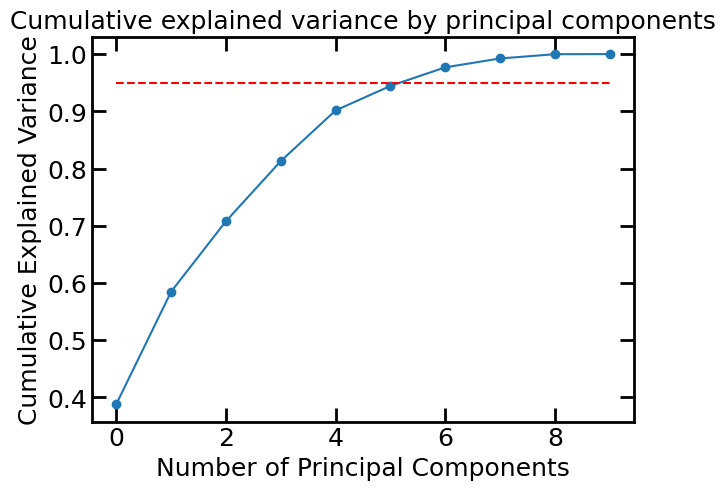

Feature loadings (coefficients linking features to PCs):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Depthm,0.395144,0.102242,0.144997,0.103328,-0.099558,0.865518,-0.089307,-0.117400,-0.127823,0.067655
T_degC,-0.453868,-0.215913,0.109661,0.084164,0.002111,0.149516,0.457163,-0.190206,-0.169385,0.657305
Salnty,0.413192,-0.274434,0.075710,0.063793,0.053409,-0.035474,0.698249,-0.133368,0.425065,-0.232435
STheta,0.488803,0.077752,-0.081087,-0.069569,0.020924,-0.208905,-0.199013,0.173638,0.350575,0.711950
Oxy_umol/kg,-0.475860,0.085278,0.034326,-0.022127,-0.076952,0.320912,-0.128618,0.145402,0.785003,-0.042391
Quarter,-0.021646,0.054516,-0.097199,0.833298,0.529228,-0.018799,-0.097147,0.023037,0.048167,0.001702
Lat_Dec,-0.022999,0.543549,-0.523118,-0.106164,0.054848,-0.007741,0.120964,-0.626324,0.092538,0.023592
Lon_Dec,0.014879,-0.658369,-0.057248,-0.097458,0.142710,0.004609,-0.447591,-0.563587,0.123160,-0.005510
Bottom_D,0.014541,0.299666,0.729490,0.212815,-0.253391,-0.273624,-0.117546,-0.412935,0.095110,0.009348
Wind_Spd,-0.018311,0.180636,0.367329,-0.460865,0.783076,0.073040,0.033185,0.001721,-0.007714,0.000720


In [196]:
df_filtered = chifis_df.dropna(subset=chifis_cols)

# rescaling and PCA
X = StandardScaler().fit_transform(df_filtered[chifis_cols].values)
pca = PCA()
X_pca = pca.fit_transform(X)

# == Cumulative Explained Variance 
plt.figure(figsize=(7, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.plot([0,9], [0.95, 0.95], color = 'red', ls = '--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative explained variance by principal components", fontsize = 18)
plt.grid(True)
plt.show()

# -------------------
# 2) Loadings delle feature
# -------------------
# Ogni riga = variabile originale, ogni colonna = PC
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(chifis_cols))],
    index=chifis_cols
)

print("Feature loadings (coefficients linking features to PCs):")
display(loadings)



At the end of our analysis allowed to define the final features:

In [201]:
list(chifis_df.columns)

['Depthm',
 'T_degC',
 'Salnty',
 'STheta',
 'Oxy_umol/kg',
 'Quarter',
 'Lat_Dec',
 'Lon_Dec',
 'Bottom_D',
 'Wind_Spd']

In [199]:
chifis_df.describe()

,Depthm,T_degC,Salnty,STheta,Oxy_umol/kg,Quarter,Lat_Dec,Lon_Dec,Bottom_D,Wind_Spd
count,766895.000000,756352.000000,720195.000000,716978.000000,646220.000000,766895.000000,766895.000000,766895.000000,710496.000000,748324.000000
mean,227.268617,10.808001,33.837936,25.810096,148.940418,2.371063,31.711555,-120.111947,2580.711444,11.439302
std,320.735294,4.238018,0.459312,1.006216,90.196863,1.088061,3.660418,4.001195,1494.039783,6.756468
min,0.000000,1.440000,28.431000,20.934000,-0.434900,1.000000,18.416666,-164.083333,7.000000,0.000000
25%,49.000000,7.710000,33.483000,24.958000,61.330080,1.000000,29.778333,-122.391666,1136.000000,6.000000
50%,125.000000,10.070000,33.859000,25.981125,151.473200,2.000000,32.280000,-120.126666,3077.000000,10.000000
75%,300.000000,13.890000,34.192000,26.640000,240.440925,3.000000,33.730000,-117.800000,3931.000000,16.000000
max,5351.000000,31.140000,37.034000,27.954000,485.701800,4.000000,47.916666,-105.966666,7864.000000,71.000000


## Correlations

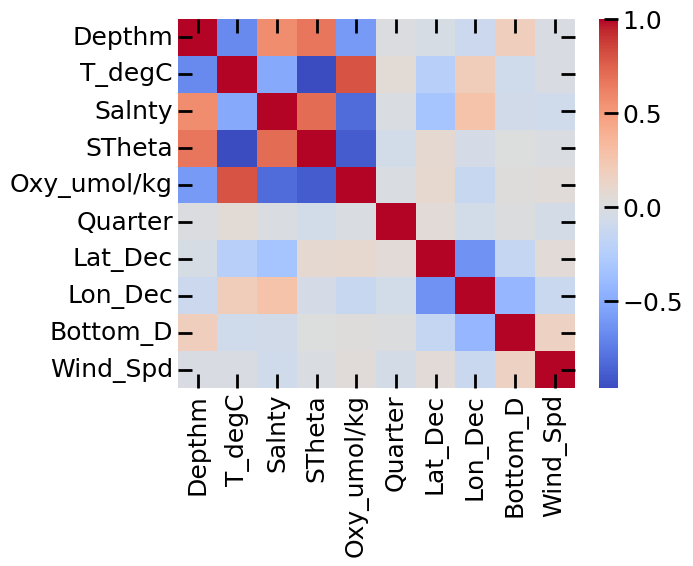

In [207]:
sns.heatmap(chifis_df.corr(), cmap="coolwarm")
plt.show()

<Figure size 1000x800 with 0 Axes>

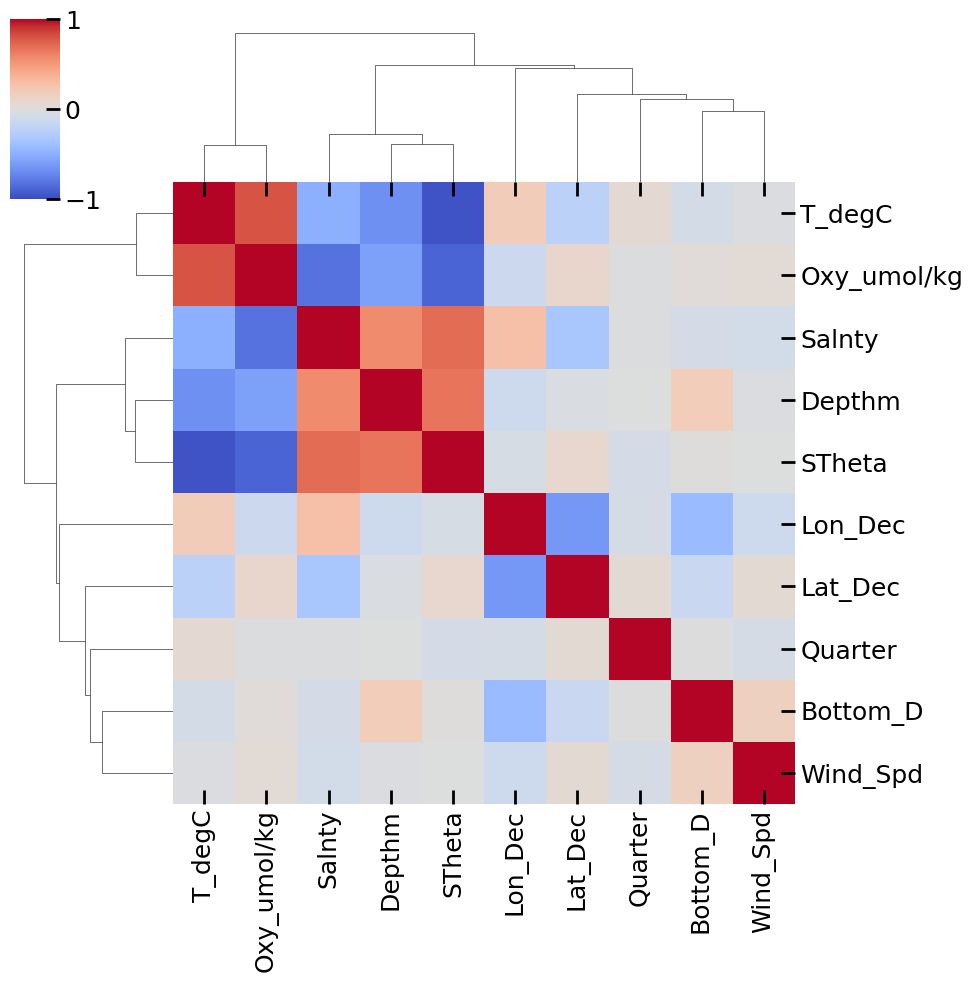

In [209]:
import numpy as np
# heatmap "a metà"
plt.figure(figsize=(10,8))
sns.clustermap(chifis_df.corr(),  cmap="coolwarm", vmin=-1, vmax=1, square=True)# mask=mask,
plt.show()


## Preliminary plots

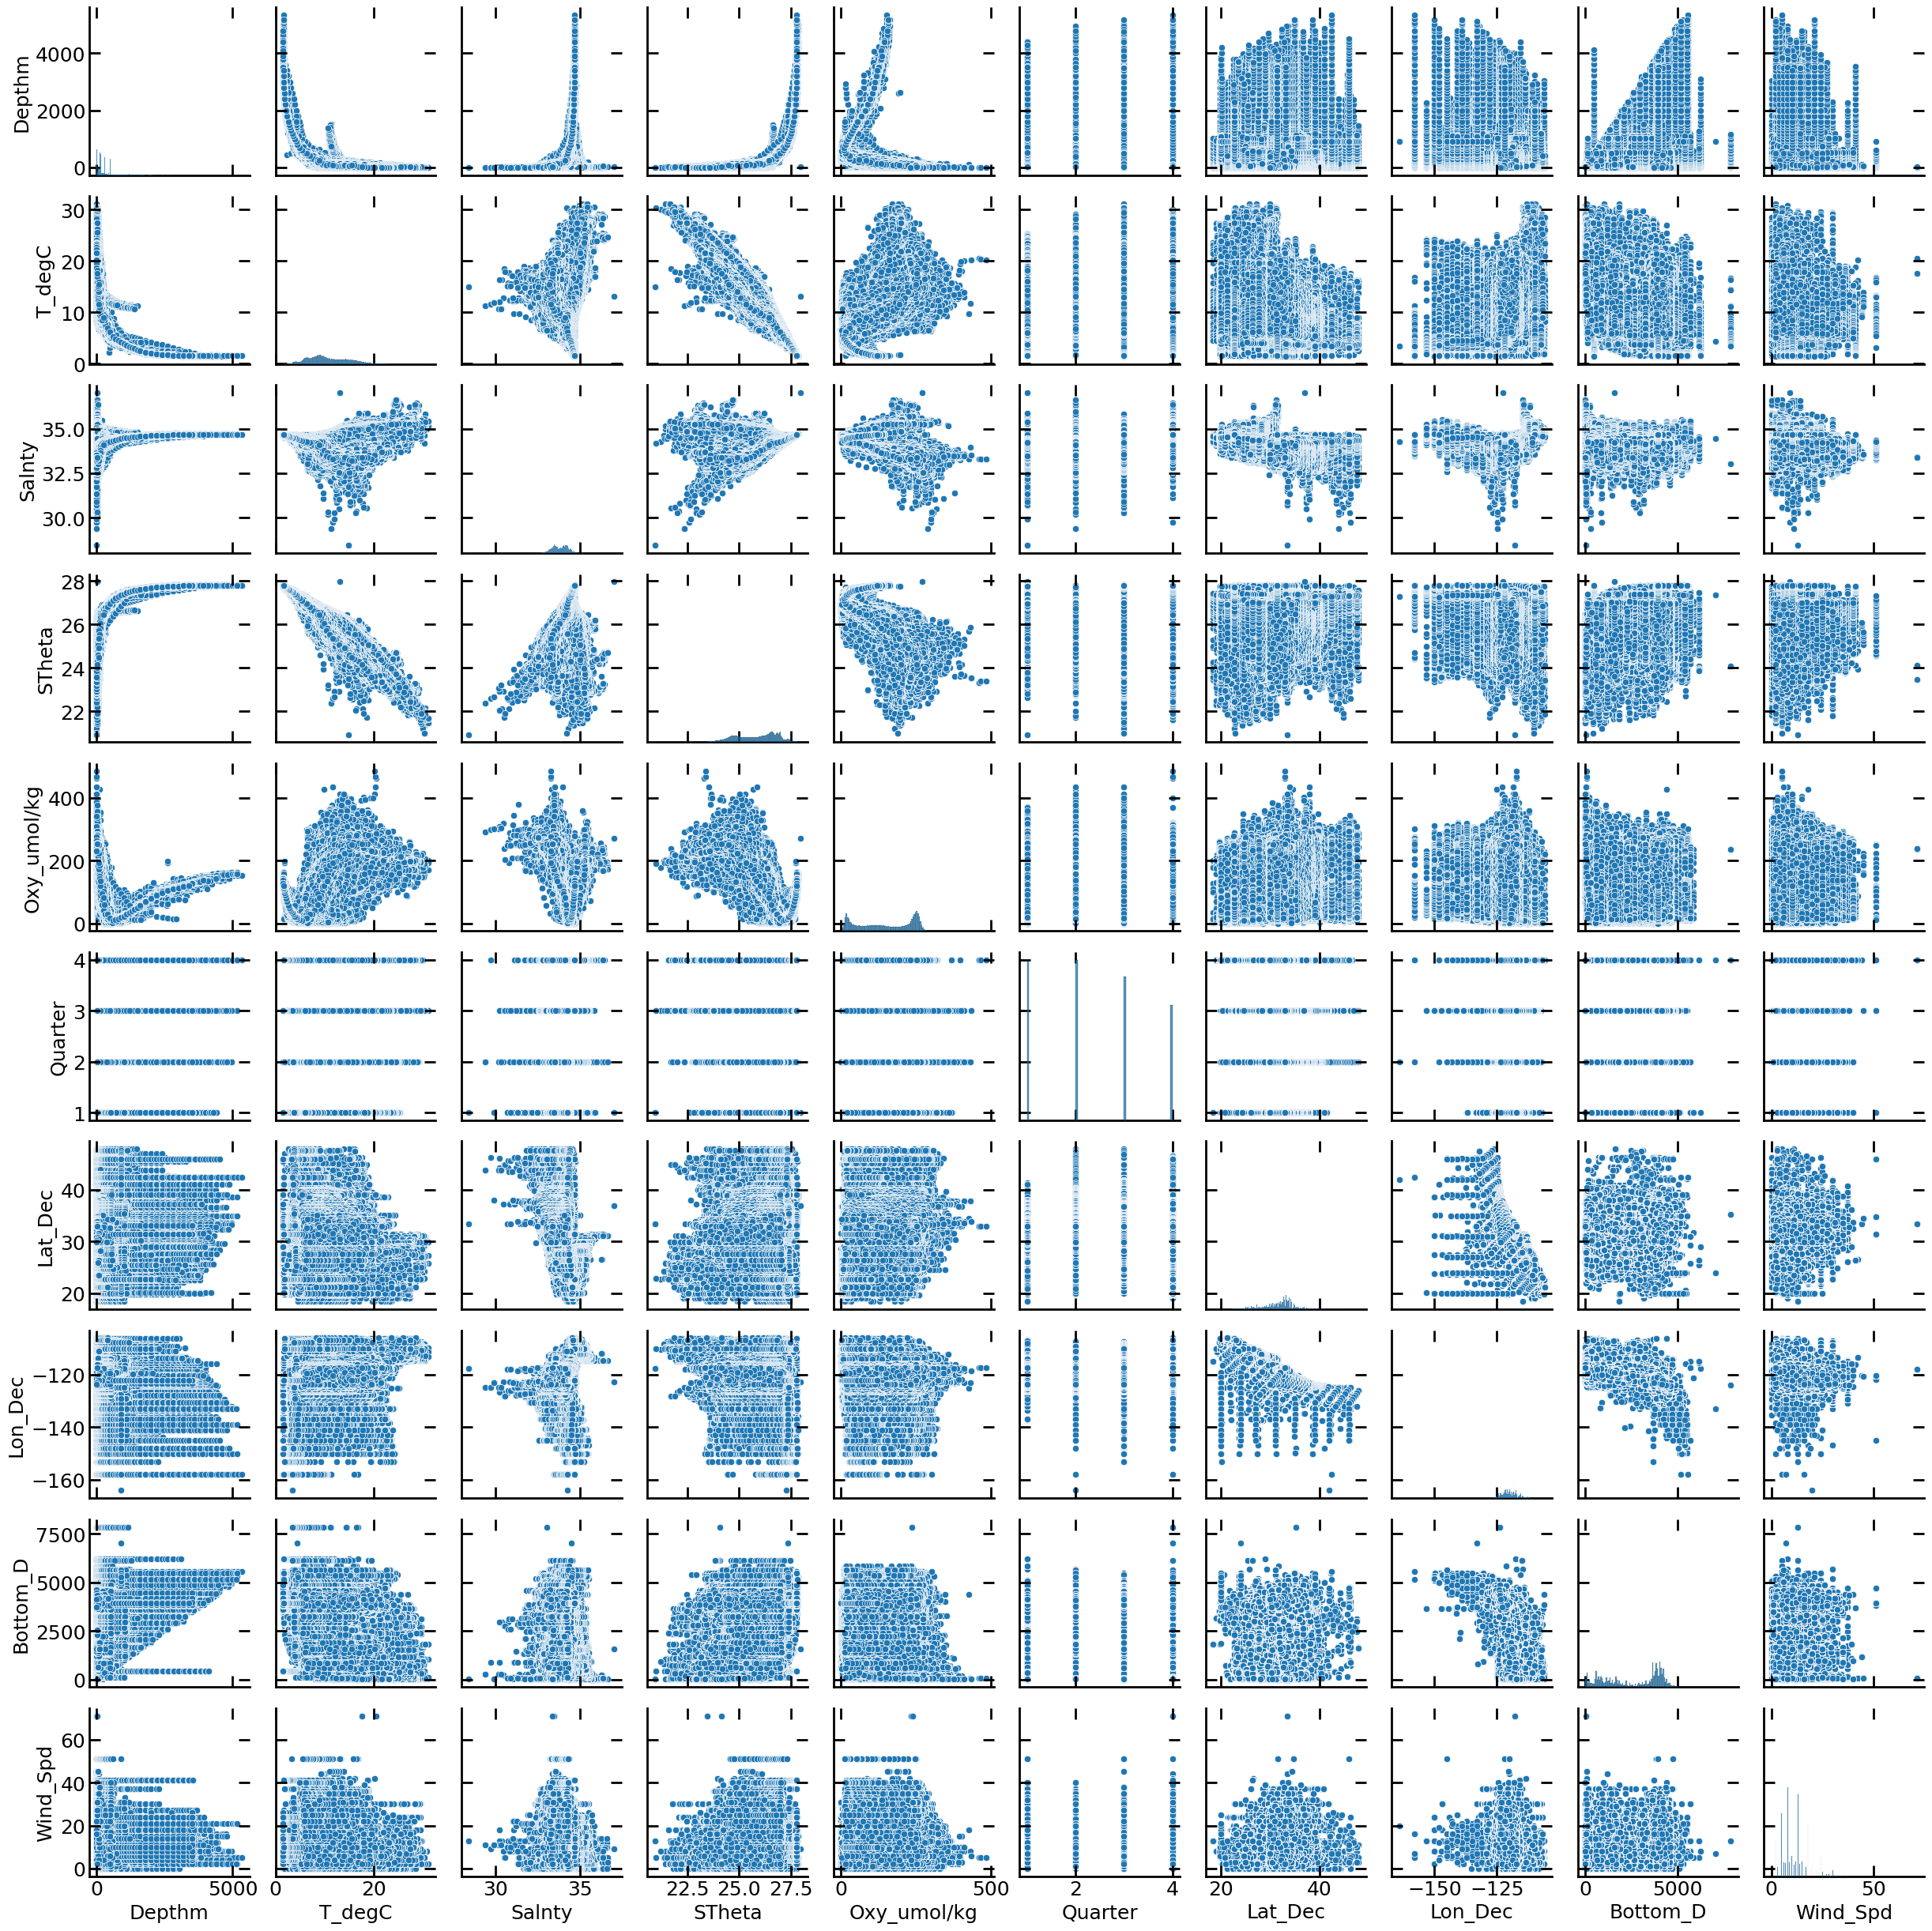

In [211]:
sns.pairplot(chifis_df)

## Saving data

In [210]:
cleaned_df.to_csv('calcofi_cleaned.csv')
chifis_df.to_csv('calcofi_chifis_df.csv')

Bibliography:
- [temperature-salinity-geodata](https://www.kaggle.com/code/angelosorge/temperature-salinity-geodata)
- [salinity-calcofi-corr-data-visual-map](https://www.kaggle.com/code/asimislam/salinity-calcofi-corr-data-visual-map/notebook)
